<a href="https://colab.research.google.com/github/sobakin706/neo/blob/main/Facebook_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
from tqdm import tqdm
import networkx as nx
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
 
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
!wget https://github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/archive/master.zip -P "/content"
ZipFile("/content/master.zip").extractall("/content/")

--2022-09-12 18:01:14--  https://github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/archive/master.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/zip/refs/heads/master [following]
--2022-09-12 18:01:14--  https://codeload.github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/master.zip’

master.zip              [   <=>              ]   1.35M  2.88MB/s    in 0.5s    

2022-09-12 18:01:15 (2.88 MB/s) - ‘/content/master.zip’ saved [1415226]



In [3]:
G = nx.read_gpickle('/content/Facebook-Social-Network-Analysis-master/Graph.pickle')
df1 = pd.read_csv('/content/Facebook-Social-Network-Analysis-master/df1.csv', index_col=[0])
                  

In [4]:
df1.head

<bound method NDFrame.head of        Node 1  Node 2  Connection
0           2       3           0
1           2      10           0
2           2      24           0
3           2     254           0
4           2     265           0
...       ...     ...         ...
50586    3902    3926           1
50587    3902    3930           1
50588    3902    3938           1
50589    3926    3930           1
50590    3926    3938           1

[50591 rows x 3 columns]>

In [5]:
print(nx.info(G))

Graph with 1295 nodes and 18321 edges


In [6]:
#making a copy of the original dataframe
df_2 = df1.copy()
 
#sorting according to the nodes
df_2.sort_values(['Node 1', 'Node 2'], inplace=True)
 
#getting the two nodes in a row in a tuple, i.e (Node 1, Node 2) and adding then to a new Edges column
edges = [(df1.iloc[i,0],df1.iloc[i,1]) for i in range(df1.shape[0])]
df_2['Edges'] = edges
 
#dropping the Node 1 and Node 2 columns and setting the Edges column as index
df_2.drop(columns=df_2.columns[:2], inplace=True)
df_2.set_index('Edges', inplace=True)
 
df_2.head()

,Connection
Edges,
"(2, 3)",0
"(2, 10)",0
"(2, 24)",0
"(2, 254)",1
"(2, 265)",1


In [7]:
df_2.tail()

,Connection
Edges,
"(3902, 3926)",1
"(3902, 3930)",1
"(3902, 3938)",1
"(3926, 3930)",1
"(3926, 3938)",1


In [8]:
df_2['Common_Neigh'] = [len(list(nx.common_neighbors(G, e[0],e[1]))) for e in df_2.index]

In [9]:
#creating a new temporary dataframe for storing the similarity measure values
df_3 = pd.DataFrame()
 
#finding jaccard coefficients
jaccard = list(nx.jaccard_coefficient(G, list(df_2.index)))
 
#storing the values in the new dataframe and setting the index as edges
df_3['Jaccard_Coef'] = [i[2] for i in jaccard]
df_3['Edges'] = [(i[0],i[1]) for i in jaccard]
df_3.set_index('Edges', inplace=True)
 
#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

In [10]:
df_3 = pd.DataFrame()
 
#finding adamic adar index
adamic_adar = list(nx.adamic_adar_index(G, list(df_2.index)))
 
#storing the values in a new dataframe and setting the index as edges
df_3['Adamic_Adar'] = [i[2] for i in adamic_adar]
df_3['index'] = [(i[0],i[1]) for i in adamic_adar]
df_3.set_index('index', inplace=True)
 
#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

In [11]:
df_3 = pd.DataFrame()
 
#finding preferential attachment
preferential_attach = list(nx.preferential_attachment(G, list(df_2.index)))
 
#storing the values in a new dataframe and setting the index as edges
df_3['Preferential_Attach'] = [i[2] for i in preferential_attach]
df_3['index'] = [(i[0],i[1]) for i in preferential_attach]
df_3.set_index('index', inplace=True)
 
#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

In [13]:
#features    
X = df_2.iloc[:,1:] 

In [14]:
#target
y = df_2['Connection']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state = 0)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
 
#this will be used only for MLP Classifier
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
#classifier
clf1 = RandomForestClassifier()
 
#parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}
 
#model
grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)
 
#training the model
grid_clf_acc1.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc1 = GridSearchCV(clf1, param_grid = param, scoring = 'roc_auc')
grid_clf_auc1.fit(X_train, y_train)
predict_proba1 = grid_clf_auc1.predict_proba(X_test)[:,1]
 
print('AUC Score', roc_auc_score(y_test, predict_proba1))
print('Grid best score : ', grid_clf_auc1.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 10, 'n_estimators': 50}
Grid best score (accuracy):  0.67969403653449
AUC Score 0.6449534904977007
Grid best score :  0.6467459665737307


In [18]:
#classifier
clf2 = GradientBoostingClassifier()
 
#parameters
param = {'learning_rate' : [.05,.1]}
 
#model
grid_clf_acc2 = GridSearchCV(clf2, param_grid = param)
 
#training the model
grid_clf_acc2.fit(X_train, y_train)
 
print('Grid best parameter (max. accuracy): ', grid_clf_acc2.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc2.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc2 = GridSearchCV(clf2, param_grid = param, scoring = 'roc_auc')
grid_clf_auc2.fit(X_train, y_train)
predict_proba2 = grid_clf_auc2.predict_proba(X_test)[:,1]
 
print('AUC Score: ', roc_auc_score(y_test, predict_proba2))
print('Grid best score: ', grid_clf_auc2.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.05}
Grid best score (accuracy):  0.6783951040359273
AUC Score:  0.6444004933065764
Grid best score:  0.645517327982199


In [19]:
#classifier
clf4 = LogisticRegression()
 
#parameters
param = {'penalty': ['l2'], 'C' :[1]}
 
#model
grid_clf_acc4 = GridSearchCV(clf4, param_grid = param)
 
#training the model
grid_clf_acc4.fit(X_train, y_train)
 

print('Grid best parameter (max. accuracy): ', grid_clf_acc4.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc4.best_score_)
 
# alternative metric to optimize over grid parameters: AUC
grid_clf_auc4 = GridSearchCV(clf4, param_grid = param, scoring = 'roc_auc')
grid_clf_auc4.fit(X_train, y_train)
predict_proba4 = grid_clf_auc4.predict_proba(X_test)[:,1]
 
print('AUC Score: ', roc_auc_score(y_test, predict_proba4))
print('Grid best score: ', grid_clf_auc4.best_score_)

Grid best parameter (max. accuracy):  {'C': 1, 'penalty': 'l2'}
Grid best score (accuracy):  0.6705730611054952
AUC Score:  0.6394036171954758
Grid best score:  0.6340326887120539


Text(0, 0.5, 'True Positive Rate')

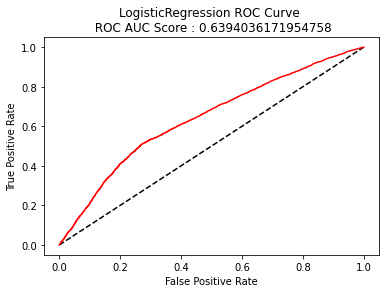

In [20]:
predict_proba4 = grid_clf_auc4.predict_proba(X_test)[:,1]
false_positive_rate4,true_positive_rate4,_ = roc_curve(y_test, predict_proba4)
roc_auc_score = auc(false_positive_rate4,true_positive_rate4)
 
#plotting
plt.plot([0,1],[0,1], 'k--')
plt.plot(false_positive_rate4,true_positive_rate4, color='red')
plt.title(f'LogisticRegression ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'True Positive Rate')

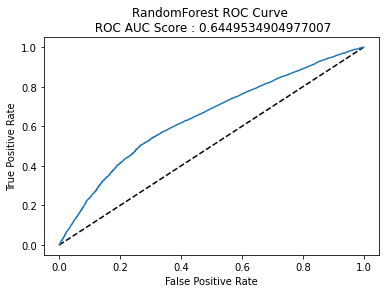

In [21]:
predict_proba1 = grid_clf_auc1.predict_proba(X_test)[:,1]
false_positive_rate1,true_positive_rate1,_ = roc_curve(y_test, predict_proba1)
roc_auc_score = auc(false_positive_rate1,true_positive_rate1)
 
#plotting
plt.plot([0,1],[0,1], 'k--')
plt.plot(false_positive_rate1,true_positive_rate1)
plt.title(f'RandomForest ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Text(0, 0.5, 'True Positive Rate')

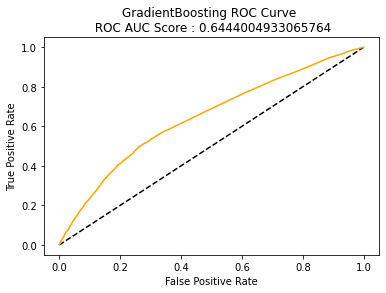

In [22]:
predict_proba2 = grid_clf_auc2.predict_proba(X_test)[:,1]
false_positive_rate2,true_positive_rate2,_ = roc_curve(y_test, predict_proba2)
roc_auc_score2 = auc(false_positive_rate2,true_positive_rate2)
 
#plotting
plt.plot([0,1],[0,1], 'k--')
plt.plot(false_positive_rate2,true_positive_rate2, color='orange')
plt.title(f'GradientBoosting ROC Curve \n ROC AUC Score : {roc_auc_score2}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [24]:
lr_y_pred = grid_clf_auc4.predict_proba(X_test)[:1]

In [25]:
def plot_confusion(y_test, y_pred):
    
    C = confusion_matrix(y_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(3,3))
    
    labels = [0,1]
    cmap=sns.light_palette("tab:blue")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

In [26]:
pred = grid_clf_acc1.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


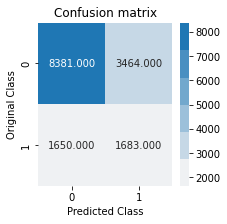

In [27]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
plot_confusion(pred,y_test)

In [28]:
print('Classification Report:Random Forest ')
print(classification_report(pred, y_test)) 

Classification Report:Random Forest 
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     11845
           1       0.33      0.50      0.40      3333

    accuracy                           0.66     15178
   macro avg       0.58      0.61      0.58     15178
weighted avg       0.72      0.66      0.69     15178



In [29]:
pred2 = grid_clf_acc2.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


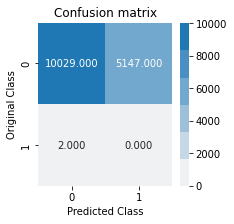

In [30]:
plot_confusion(pred2,y_test)

In [31]:
print('Classification Report:Gradient Boost ')
print(classification_report(pred2, y_test)) 

Classification Report:Gradient Boost 
              precision    recall  f1-score   support

           0       1.00      0.66      0.80     15176
           1       0.00      0.00      0.00         2

    accuracy                           0.66     15178
   macro avg       0.50      0.33      0.40     15178
weighted avg       1.00      0.66      0.80     15178



In [32]:
pred4 = grid_clf_acc4.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


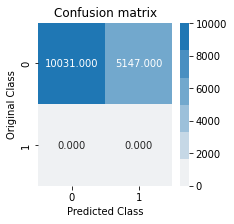

In [33]:
plot_confusion(pred4,y_test)

In [34]:
print('Classification Report:Logistic Regression ')
print(classification_report(pred4, y_test)) 

Classification Report:Logistic Regression 
              precision    recall  f1-score   support

           0       1.00      0.66      0.80     15178
           1       0.00      0.00      0.00         0

    accuracy                           0.66     15178
   macro avg       0.50      0.33      0.40     15178
weighted avg       1.00      0.66      0.80     15178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print(f' ({df_2.index[2][0]},{df_2.index[2][1]}) node pair features : {X.iloc[2,:]}')
 
# its position in X_train
print(f'Index of ({df_2.index[2][0]},{df_2.index[2][1]}) node pair in X_train : {np.where(X_train.index == X.index[2])[0][0]}')



 (2,24) node pair features : Common_Neigh            0.0
Jaccard_Coef            0.0
Adamic_Adar             0.0
Preferential_Attach    27.0
Name: (2, 24), dtype: float64
Index of (2,24) node pair in X_train : 20367


In [36]:
print(f' ({df_2.index[5][0]},{df_2.index[5][1]}) node pair features : {X.iloc[2,:]}')
 
# its position in X_train
print(f'Index of ({df_2.index[5][0]},{df_2.index[5][1]}) node pair in X_train : {np.where(X_train.index == X.index[5])[0][0]}')

 (2,345) node pair features : Common_Neigh            0.0
Jaccard_Coef            0.0
Adamic_Adar             0.0
Preferential_Attach    27.0
Name: (2, 24), dtype: float64
Index of (2,345) node pair in X_train : 23166


In [37]:
predict_proba = grid_clf_acc1.predict_proba(X_train_scaled[np.where(X_train.index == X.index[5])[0][0]].reshape(1,-1))[:,1]
 
print(f'Probability of nodes {df_2.index[5][0]} and {df_2.index[5][1]} to form a link is : {float(predict_proba)*100 : .2f}%')

Probability of nodes 2 and 345 to form a link is :  28.32%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [38]:
X_train

,Common_Neigh,Jaccard_Coef,Adamic_Adar,Preferential_Attach
"(266, 2747)",0,0.000000,0.000000,77
"(1312, 1376)",33,0.358696,7.923614,3094
"(1941, 2428)",42,0.269231,10.017940,9401
"(2668, 2730)",4,0.148148,1.298760,228
"(1359, 1791)",30,0.348837,7.185266,3264
...,...,...,...,...
"(1433, 1962)",0,0.000000,0.000000,1168
"(2142, 2276)",61,0.685393,14.353833,5504
"(1938, 2386)",56,0.691358,13.075657,4620
"(1997, 2619)",48,0.640000,11.163682,3770


In [ ]:
df_2[:10]

,Connection,Common_Neigh,Jaccard_Coef,Adamic_Adar,Preferential_Attach
"(2, 3)",0,0,0.0,0.0,21
"(2, 10)",0,0,0.0,0.0,18
"(2, 24)",0,0,0.0,0.0,27
"(2, 254)",1,0,0.0,0.0,30
"(2, 265)",1,0,0.0,0.0,54
"(2, 345)",0,0,0.0,0.0,21
"(2, 368)",0,0,0.0,0.0,45
"(2, 446)",0,0,0.0,0.0,42
"(2, 456)",0,0,0.0,0.0,84
"(2, 510)",0,0,0.0,0.0,51
